In [1]:
# default_exp subcoco_retnet_lightning

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Exploring Object Detection using Pytorch Lightning Only

Instead of using higher level library such as IceVision, I am gonna try using what's in Torch Vision, see [example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

To force some learning, I shall attempt to port the example to [Pytorch-Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as it removes a lot of boiler plate code and standardized Pytorch usage. It also makes advanced features like gradient accumulation and multi-GPU multi-node training simple.

In [2]:
#export
import cv2, json, os, requests, sys, tarfile, torch, torchvision
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import random
import torch.nn.functional as F
import torch.multiprocessing

from collections import defaultdict
from functools import reduce
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection import RetinaNet, retinanet_resnet50_fpn

from torchvision import transforms

from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
#hide

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    os.chdir('/content/drive/My Drive/ColabData')
    print(f'Current Directory is now {os.getcwd()}')
    !wget -O 'mcbbox/subcoco_utils.py' https://raw.githubusercontent.com/bguan/mcbbox/master/mcbbox/subcoco_utils.py
    !wget -O 'mcbbox/subcoco_lightning_utils.py' https://raw.githubusercontent.com/bguan/mcbbox/master/mcbbox/subcoco_lightning_utils.py
    !pip install pytorch_lightning torchvision gpumonitor albumentations==0.5.0
else:
    from nbdev.showdoc import *


In [4]:
#export
import albumentations as A
import pytorch_lightning as pl
from albumentations.pytorch import ToTensorV2
from gpumonitor.monitor import GPUStatMonitor
from gpumonitor.callbacks.lightning import PyTorchGpuMonitorCallback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.core.step_result import TrainResult
from mcbbox.subcoco_utils import *
from mcbbox.subcoco_lightning_utils import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}, Albumentation {A.__version__}")
if torch.cuda.is_available(): monitor = GPUStatMonitor(delay=1)

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.0, pytorch_lightning 1.0.4, Albumentation 0.5.0
Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.0, pytorch_lightning 1.0.4, Albumentation 0.5.0


# Setup the Run

Centralize test run vs prod time parameters

In [5]:
#hide
test = False
if test:
    img_sz, bs, acc, workers, head_runs, full_runs = 128, 4, 8, 1, 1, 1
    datadir, url, img_subdir = '/tmp', 'http://files.fast.ai/data/examples/coco_tiny.tgz', 'train'
else:
    img_sz, bs, acc, workers, head_runs, full_runs = 384, 3, 12, 4, 5, 20
    datadir, url, img_subdir = 'workspace', 'https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', 'train_sample'
    
stem = Path(url).stem
img_dir=f'{datadir}/{stem}/{img_subdir}'

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

## Check Annotations

Let's download and inspect the annotation file that comes with the coco tiny dataset...

In [6]:
#hide
train_json = fetch_subcoco(datadir=datadir, url=url, img_subdir=img_subdir)
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 318219, 'file_name': '000000318219.jpg'},
 [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image... Print out number of boxes per category to see if the distribution is not too unbalanced...

In [7]:
#hide
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
{ stats.cat2name[stats.lbl2cat[lid]]: len(ibs) for lid, ibs in stats.l2ibs.items()}

Categories 6, Images 21837, Boxes 87106, avg (w,h) (575.6857626963424, 481.71420066859)avg cats/img 7.0, avg boxs/img 4.0, avg boxs/cat 14517.7.
Image means by channel [115.64436835 103.2992867   91.73613059], std.dev by channel [64.16724017 62.63021182 61.92975836]


{'tv': 5805,
 'book': 24715,
 'chair': 38491,
 'vase': 6613,
 'remote': 5703,
 'couch': 5779}

## Look at Images

Let's look at an image annotation.

In [8]:
best_img_pos = None
max_boxs = 0
for img_pos in range(len(train_json['images'])):  
    img_id = train_json['images'][img_pos]['id']
    l2bs = stats.img2l2bs.get(img_id, {})
    n_boxs =  reduce((lambda x, y: x + y), [1 if len(bs) > 0 else 0 for bs in l2bs.values()], 0)
    if n_boxs >= max_boxs:
        best_img_pos = img_pos
        max_boxs = n_boxs

print(f'best_img_pos {best_img_pos}')
best_img_id = train_json['images'][best_img_pos]['id']
l2bs = stats.img2l2bs[best_img_id]
best_img_fname = stats.img2fname[best_img_id]
best_img_id, best_img_fname, l2bs

best_img_pos 21804


(350506,
 '000000350506.jpg',
 {0: [],
  1: [(174.44, 241.01, 77.53, 77.53)],
  2: [(252.42, 274.42, 184.68, 95.97)],
  3: [(71.5, 220.19, 82.28, 82.84)],
  4: [(226.18, 314.93, 25.0, 6.4)],
  5: [(171.07, 329.67, 51.88, 20.65)],
  6: [(395.51, 261.61, 21.0, 25.29)]})

## Overlay Boxes and Labels from Annotation

Let's overlay bounding boxes and labels over the image to confirm our understanding of the data.
Pick some random image to test drive the box overlay code...

img = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x7FF286422D00>


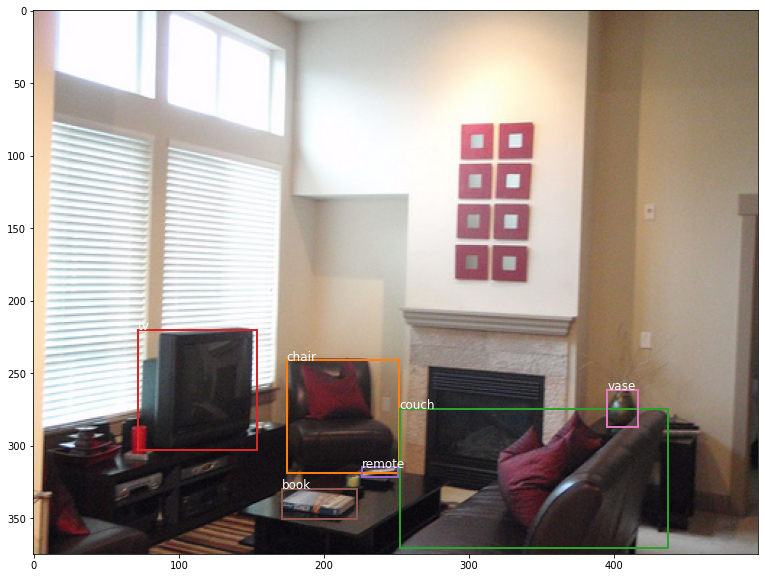

In [9]:
img = Image.open(Path(img_dir)/stats.img2fname[best_img_id])
print(f"img = {img}")
overlay_img_bbox(img, stats.img2l2bs[best_img_id], stats.lbl2name)

## Packaging Model and Metric Into A Lightning Module

In [10]:
# export
class RetinaNetModule(LightningModule):
    
    def __init__(self, lbl2name:dict={}, img_sz=128, lr:float=1e-2):
        LightningModule.__init__(self)
        self.model = retinanet_resnet50_fpn(pretrained=False, num_classes=len(lbl2name)+1, pretrained_backbone=True)
        self.img_sz = img_sz
        self.lr = lr

        # Hacked to avoid model builtin call to GeneralizedRCNNTransform.normalize() as already done in augmentation pipeline
        def noop_normalize(image): return image 

        # Hacked to avoid model builtin call to GeneralizedRCNNTransform.resize() as already done in augmentation pipeline
        def noop_resize(image, target): return image, target  

        # HACK!! IceVision does this too!
        self.model.transform.normalize = noop_normalize
        self.model.transform.resize = noop_resize
        
    def freeze_head(self):
        for param in self.model.head.parameters():
            param.requires_grad = False
        
    def unfreeze_head(self):
        for param in self.model.head.parameters():
            param.requires_grad = True
        
    def freeze_backbone(self):
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        
    def unfreeze_backbone(self):
        for param in self.model.backbone.parameters():
            param.requires_grad = True
        
    def training_step(self, train_batch, batch_idx):
#         print('Entering training_step')
        self.model.cuda()
        xs, ys = train_batch
        self.model.train()
        for y in ys:
            if len(y.get('boxes',[])) <= 0:
                print(f"Warning: Y has no boxes! {y}")
        losses = self.model.forward(xs, ys)
        loss = sum(losses.values())
#         print(f'Exiting training_step, returning {loss}')
        return loss # has 2 types of losses: classification, bbox_regression

    def avg_acc(self, preds, targets):
        metrics = []
        for p,t in zip(preds, targets):
            metrics.append(calc_wavg_F1(p, t, .5, .5))
        return sum(metrics)/len(targets)

    def validation_step(self, val_batch, batch_idx):
#         print('Entering validation_step')
        self.model.cpu()
        self.model.eval()
        
        # turn off auto gradient for validation step
        with torch.no_grad():
            xs, ys = val_batch
            xs_cpu = [ x.cpu() for x in xs ]
            ys_cpu = [ { k:v.cpu() for k,v in y.items() } for y in ys ]
            preds = self.model.forward(xs_cpu)
            avg_acc = self.avg_acc(preds, ys_cpu)
        
        result = {'val_acc': avg_acc}
#         print(f'Exiting validation_step, returning {result}')
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch, but gradient accumulation may result in last row being different size
        val_acc_sum = sum([ o['val_acc'] for o in outputs ])
        self.log_dict({'val_acc': val_acc_sum/len(outputs)})
    
    def forward(self, imgs):
        self.model.eval()
        return self.model.forward(imgs)

## Neural Network Architecture Model

On my Dell XPS15 GTX-1050 GPU w/ 4GB VRAM,  I can average 1 epoc every 120 min or so, at bs=2 acc=16, img 384x384, with unfrozen backbone.

Using my GCP w/ V100 of 16GB VRAM, I can fit bs=12 for sample_coco, acc=16, img 384x384, with unfrozen backbone, 1 epoc every ~25 minutes.

In [11]:
#export
def run_training(stats:CocoDatasetStats, modeldir:str, img_dir:str, resume_ckpt_fname:str=None, 
                 img_sz=384, bs=12, acc=4, workers=4, head_runs=50, full_runs=200,
                 monitor='val_acc', mode='max', save_top=-1):
    
    retnet_model = RetinaNetModule(lbl2name=stats.lbl2name, img_sz=img_sz)

    print(f"Training with image size {img_sz}, auto learning rate, for {head_runs}+{full_runs} epochs.")
    chkpt_cb = ModelCheckpoint(
        filename='retnet-subcoco-'+str(img_sz)+'-{epoch:03d}-{'+monitor+':.3f}',
        dirpath=modeldir,
        save_last=True,
        monitor=monitor,
        mode=mode,
        save_top_k=save_top,
        verbose=True,
    )
    early_stop_cb = EarlyStopping(
       monitor=monitor,
       min_delta=0.001,
       patience=20,
       verbose=True,
       mode=mode
    )
    gpumon_cb = PyTorchGpuMonitorCallback(delay=1)
    callbacks = [early_stop_cb, gpumon_cb]
    resume_ckpt = f'{modeldir}/{resume_ckpt_fname}' if resume_ckpt_fname != None else None
    if resume_ckpt and os.path.isfile(resume_ckpt):
        try:
            print(f'Loading previously saved model: {resume_ckpt}...')
            retnet_model = FRCNN.load_from_checkpoint(resume_ckpt, lbl2name=stats.lbl2name)
        except Exception as e:
            print(f'Unexpected error loading previously saved model {resume_ckpt}: {e}')
    elif resume_ckpt:
        print(f'Failed to find {resume_ckpt}')
    
    # transforms for images
    bbox_aware_train_tfms=A.Compose([
        A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9),
        A.Resize(width=img_sz, height=img_sz),
        A.HorizontalFlip(p=0.5), 
        A.RGBShift(),
        A.RandomBrightnessContrast(),
        A.Blur(blur_limit=(1, 3)),
        #A.Normalize(mean=stats.chn_means/255, std=stats.chn_stds/255)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    bbox_aware_val_tfms=A.Compose([
        A.Resize(width=img_sz, height=img_sz),
        #A.Normalize(mean=stats.chn_means/255, std=stats.chn_stds/255)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    # train head only, since using less params, double the bs and half the grad accumulation cycle to use more GPU VRAM
    if head_runs > 0:
        head_dm = SubCocoDataModule(img_dir, stats, shuffle=False,
                                    train_transforms=bbox_aware_train_tfms, val_transforms=bbox_aware_val_tfms,
                                    bs=bs, workers=workers)
        trainer = Trainer(gpus=1, auto_lr_find=True, max_epochs=head_runs, default_root_dir = 'models',
                          callbacks=callbacks, checkpoint_callback=chkpt_cb, accumulate_grad_batches=acc)
        retnet_model.freeze_backbone()
        trainer.fit(retnet_model, head_dm)

    if full_runs > 0:
        # finetune head and backbone
        full_dm = SubCocoDataModule(img_dir, stats, shuffle=False,
                                    train_transforms=bbox_aware_train_tfms, val_transforms=bbox_aware_val_tfms,
                                    bs=bs, workers=workers)
        trainer = Trainer(gpus=1, auto_lr_find=True, max_epochs=full_runs, default_root_dir = 'models',
                          callbacks=callbacks, checkpoint_callback=chkpt_cb, accumulate_grad_batches=acc)
        retnet_model.unfreeze_backbone()
        trainer.fit(retnet_model, full_dm)
        
    last_model_fpath=Path(chkpt_cb.last_model_path)
    saved_last_model_fpath=str(last_model_fpath.parent/f'retnet-subcoco-{img_sz}-last')+last_model_fpath.suffix
    os.rename(str(last_model_fpath), saved_last_model_fpath)
    
    return retnet_model, saved_last_model_fpath

In [ ]:
if torch.cuda.is_available():
    monitor.display_average_stats_per_gpu()
    retnet_model, last_model_path = run_training(
        stats, 'models', img_dir, resume_ckpt_fname=f'retnet_subcoco-{img_sz}-last.ckpt', img_sz=img_sz, 
        bs=bs, acc=acc, workers=workers, head_runs=head_runs, full_runs=full_runs,
        monitor='val_acc', mode='max', save_top=-1,
    )

    print(f"last_model_path saved = {last_model_path}")

[0] GeForce GTX 1050 | 46'C,  18 % |  2126 /  4042 MB | root(803M) brian(290M) brian(330M)
Training with image size 384, auto learning rate, for 5+20 epochs.
Failed to find models/retnet_subcoco-384-last.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32 M  


## Inference

Time to see how well the model can perform.

In [ ]:
if torch.cuda.is_available():
    x, y = dataset[best_img_pos] 
    pimg = torchvision.transforms.ToPILImage()(x)
    tgt_l2bs = defaultdict(empty_list)
    for l, b in zip(list(y['labels']), y['boxes']):
        tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

    overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

    retnet_model.eval()
    pred = retnet_model.forward([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0], cutoff=0.5)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

Compare with Original Image before transformations incl. Normalization and Resize.

In [ ]:
if torch.cuda.is_available():
    img_id = int(y['image_id'])
    img = Image.open(Path(img_dir)/stats.img2fname[img_id])
    overlay_img_bbox(img, stats.img2l2bs[img_id], stats.lbl2name)

## Reloading Saved Checkpoint using Pytorch Lightning

In [ ]:
#hide
if torch.cuda.is_available():
    pretrained_model = RetinaNetModule.load_from_checkpoint(last_model_path, lbl2name=stats.lbl2name)
    pretrained_model.freeze()
    x, y = dataset[best_img_pos] 
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0])
    pimg = torchvision.transforms.ToPILImage()(x)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

## Saving and Reloading using Underlying Pytorch

In [ ]:
# export
def save_final(retnet_model, model_save_path):
    torch.save(retnet_model.model.state_dict(), model_save_path)

In [ ]:
if torch.cuda.is_available():
    model_save_path = 'models/retnet-final.pth'
    save_final(retnet_model, model_save_path)
    pretrained_model = RetinaNetModule(lbl2name=stats.lbl2name)
    pretrained_model.model.load_state_dict(torch.load(model_save_path))
    pretrained_model.freeze()

In [ ]:
if torch.cuda.is_available():
    x, y = dataset[best_img_pos] 
    pred = pretrained_model([x])
    pred_l2bs = digest_pred(stats.lbl2name, pred[0])
    pimg = torchvision.transforms.ToPILImage()(x)

    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)